### Importing Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import os
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import torch.nn as nn
import random
import random
from torchvision import transforms, datasets
from skimage.segmentation import mark_boundaries
from torchvision.utils import make_grid
from torchvision import models, transforms
from torchvision.datasets import CIFAR10


In [3]:
#Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
dataset = ConcatDataset([dataset_train, dataset_test])

100%|██████████| 170498071/170498071 [00:06<00:00, 25291320.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


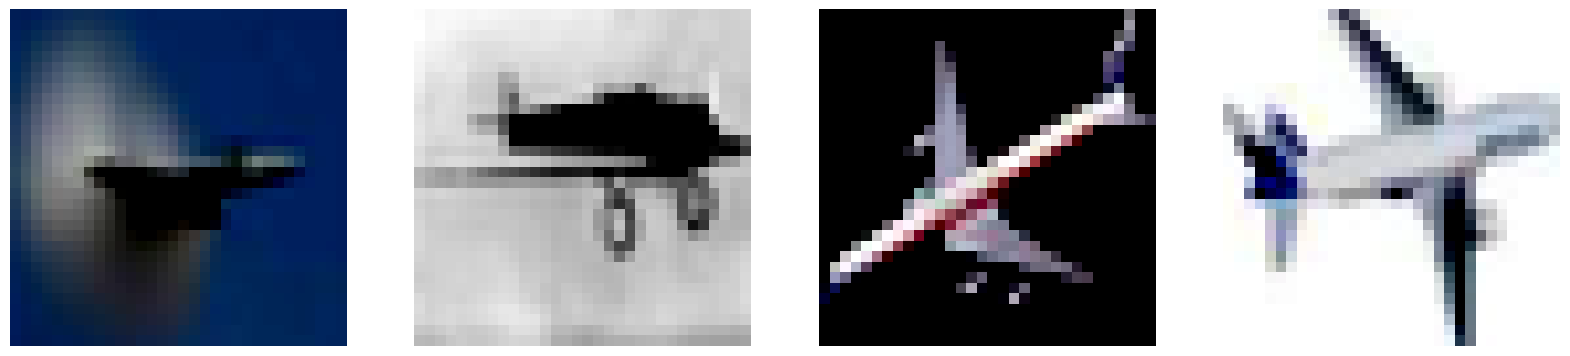

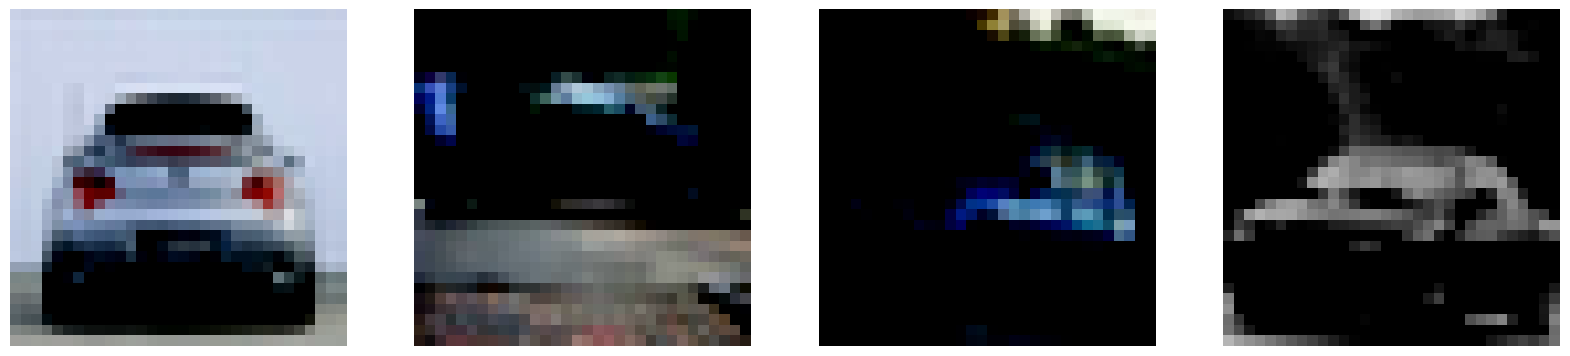

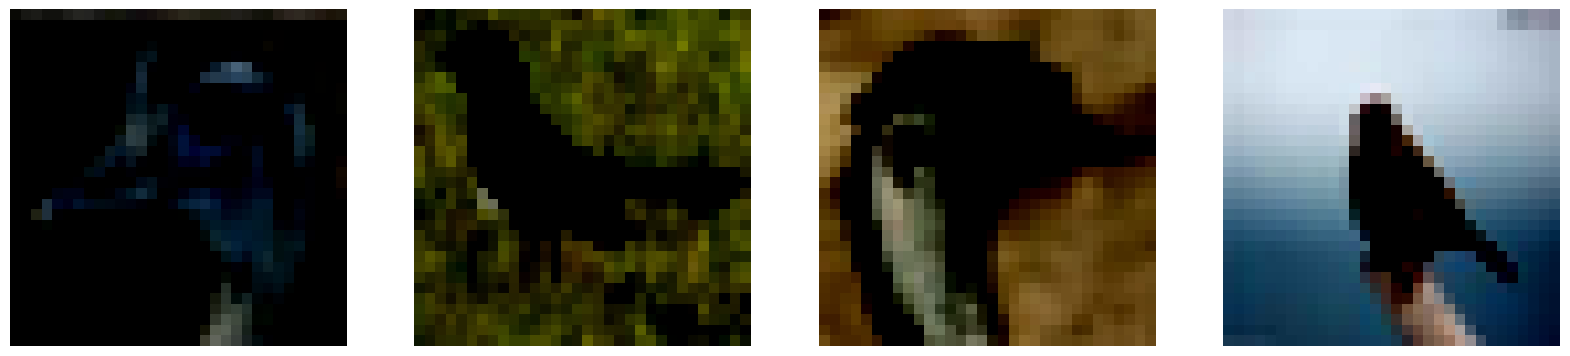

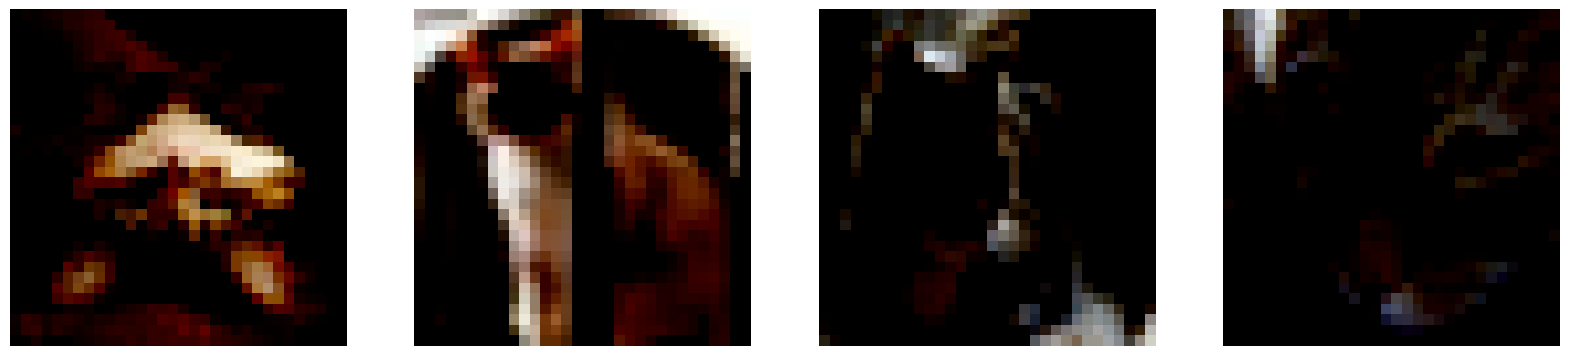

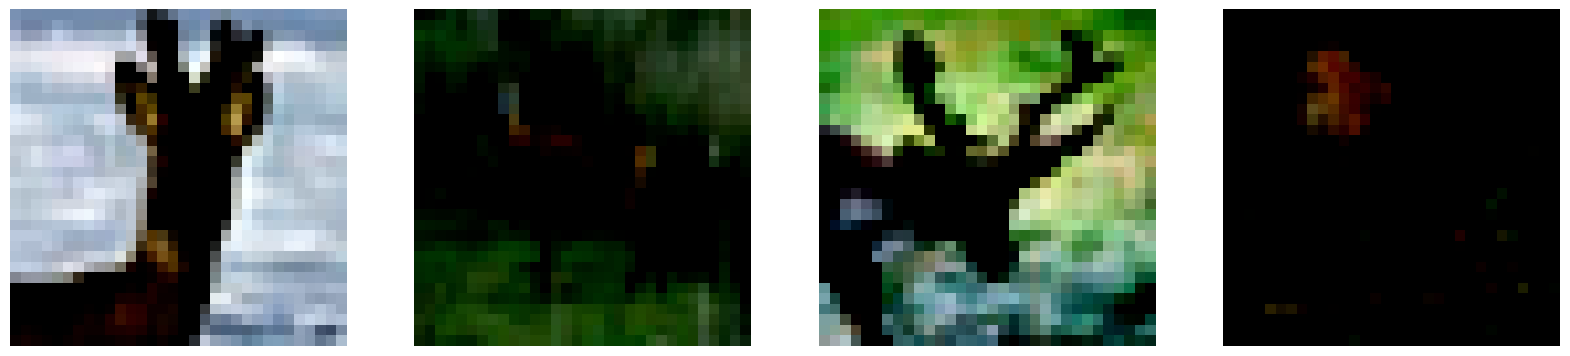

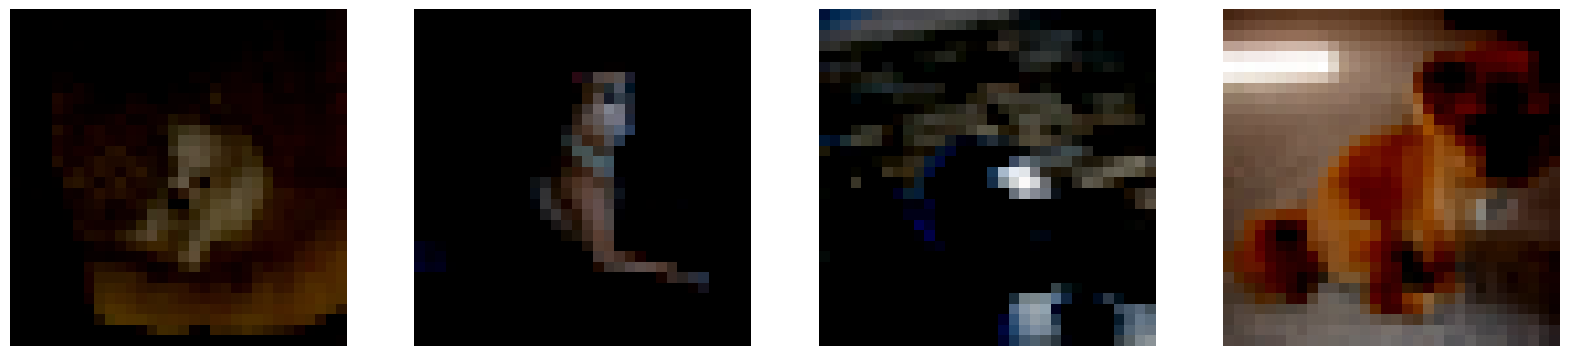

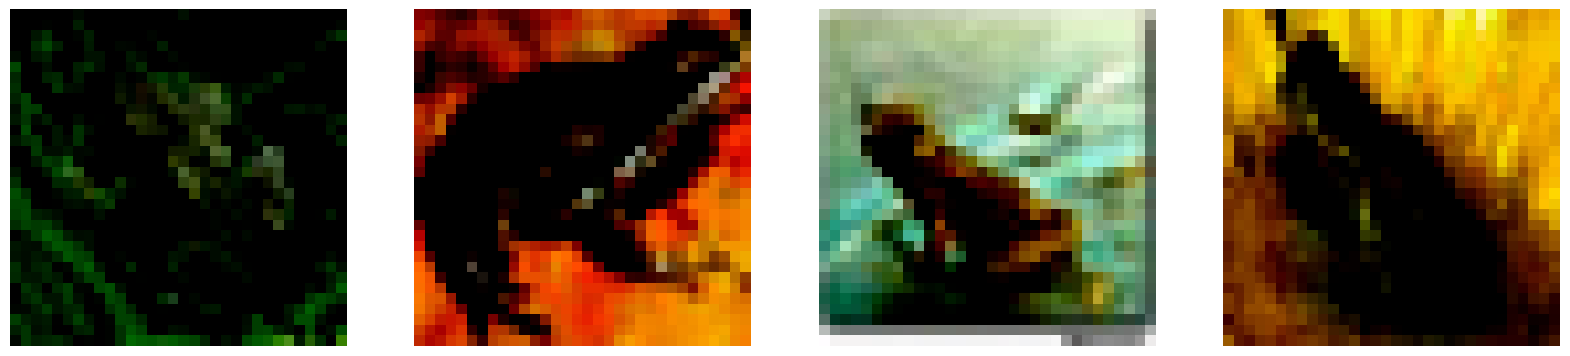

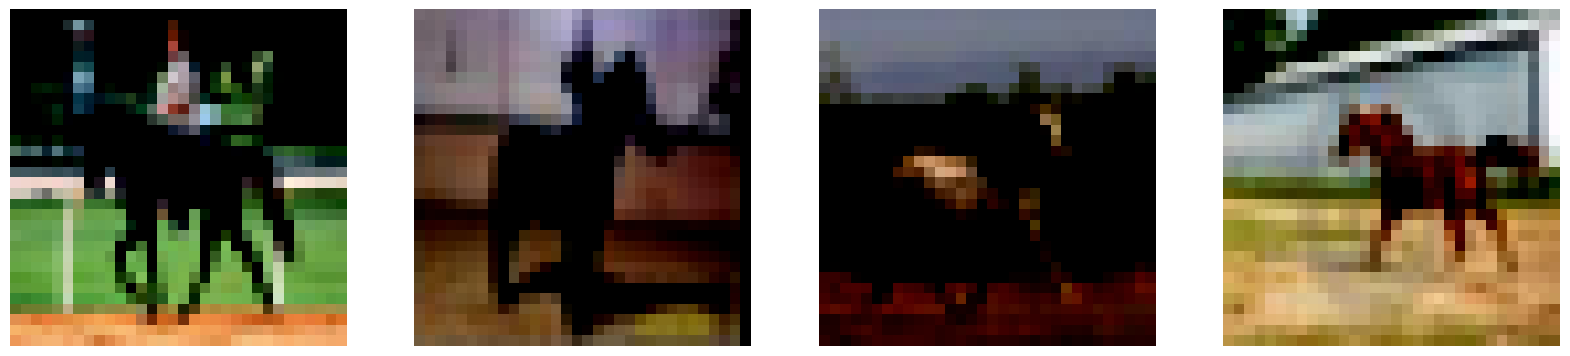

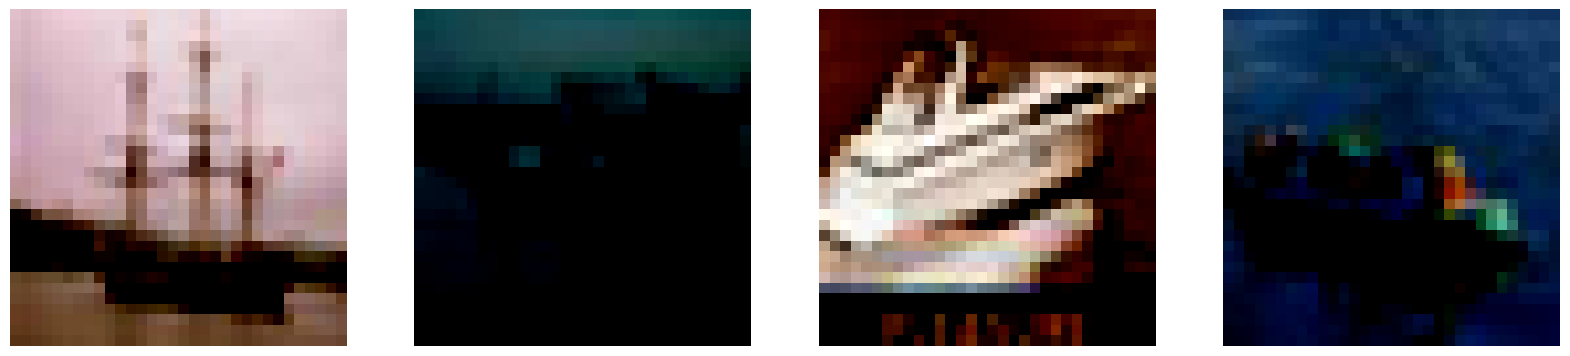

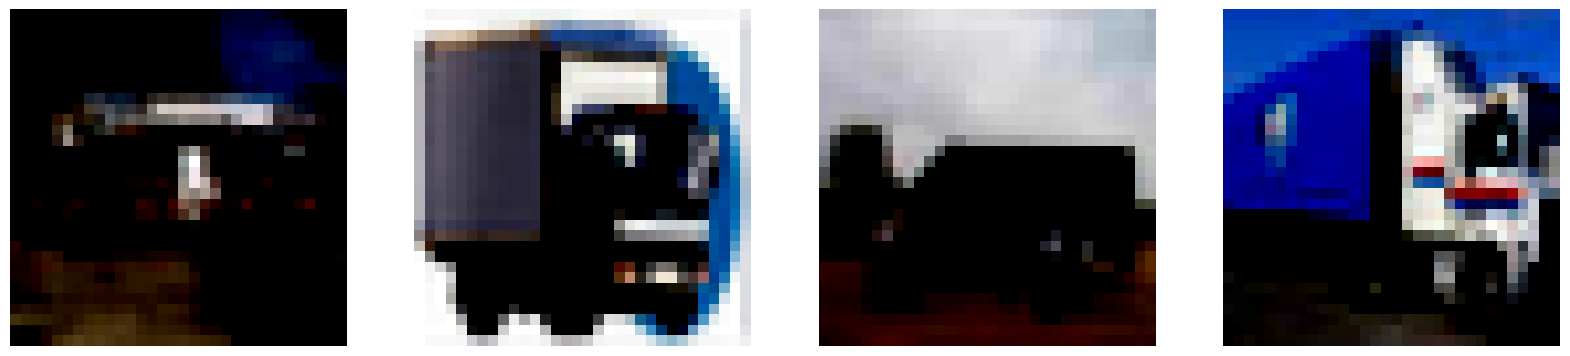

In [5]:
def show_samples_per_class(dataset, num_classes, samples_per_class=4):
    class_indices = [[] for _ in range(num_classes)]


    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)


    for cls in range(num_classes):
        plt.figure(figsize=(5 * samples_per_class, 5))
        for i in range(samples_per_class):
            plt.subplot(1, samples_per_class, i + 1)
            idx = random.choice(class_indices[cls])
            image, label = dataset[idx]
            if image.shape[0] == 3:

                plt.imshow(image.permute(1, 2, 0))
            else:

                plt.imshow(image.squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()

show_samples_per_class(dataset, num_classes=10)

In [ ]:
num_classes = len(set([label for dataset in dataset.datasets for _, label in dataset]))
classes = dataset_train.classes
num_train = int(0.7 * len(dataset))
num_val = int(0.15 * len(dataset))
num_test = len(dataset) - num_train - num_val

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[num_train, num_val, num_test],
                                                        generator=torch.Generator().manual_seed(7))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("classes are:", classes)
print("Number of classes in the dataset:", num_classes)
print("Length of dataset",len(dataset))
print("Length of train_size:", len(train_dataset))
print("Length of val_size:", len(val_dataset))
print("Length of test_size:", len(test_dataset))

classes are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes in the dataset: 10
Length of dataset 60000
Length of train_size: 42000
Length of val_size: 9000
Length of test_size: 9000


## VGG13 Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGG13(nn.Module):
    def __init__(self):
        super(VGG13, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.fc_layers(x)
        return x

model = VGG13()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
summary(model,input_size=(3,64,64))






VGG13(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (

## Training and validation

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = next(iter(train_loader))
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 38.25%  Train Loss: 1.658847289270462  Validation Accuracy: 53.04%  Validation Loss: 1.282720590314121
Epoch: 2  Train Accuracy: 59.42%  Train Loss: 1.1376242044309504  Validation Accuracy: 65.86%  Validation Loss: 0.9672477367921923
Epoch: 3  Train Accuracy: 69.04%  Train Loss: 0.8917420547302455  Validation Accuracy: 70.86%  Validation Loss: 0.8386869460132951
Epoch: 4  Train Accuracy: 75.43%  Train Loss: 0.7173723485008948  Validation Accuracy: 71.56%  Validation Loss: 0.831736832011676
Epoch: 5  Train Accuracy: 78.72%  Train Loss: 0.6257915907798837  Validation Accuracy: 70.91%  Validation Loss: 0.9108458112740347
Epoch: 6  Train Accuracy: 82.11%  Train Loss: 0.5309013956122928  Validation Accuracy: 74.24%  Validation Loss: 0.8038131668635294
Epoch: 7  Train Accuracy: 84.63%  Train Loss: 0.4555921626009353  Validation Accuracy: 75.43%  Validation Loss: 0.776863083560416
Epoch: 8  Train Accuracy: 86.49%  Train Loss: 0.40799754356775475  Validation Accuracy:

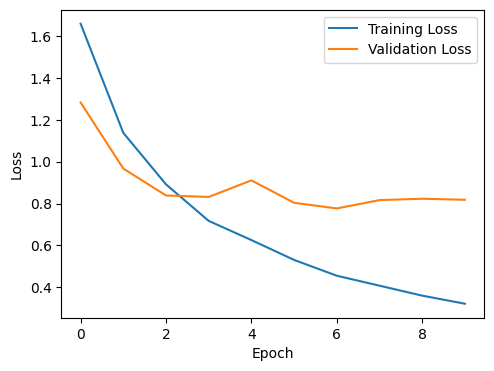

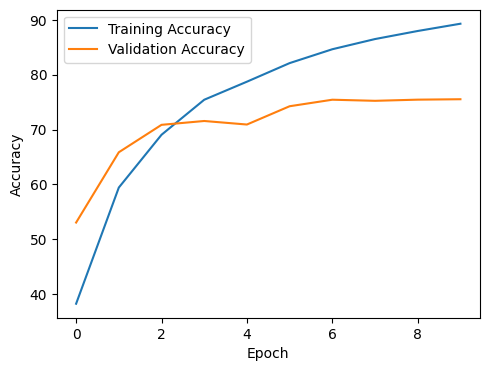

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=10)

In [ ]:
#Test Accuracy and Loss
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))



In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 75 %
Test Loss: 0.8097207529325012


In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    #model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



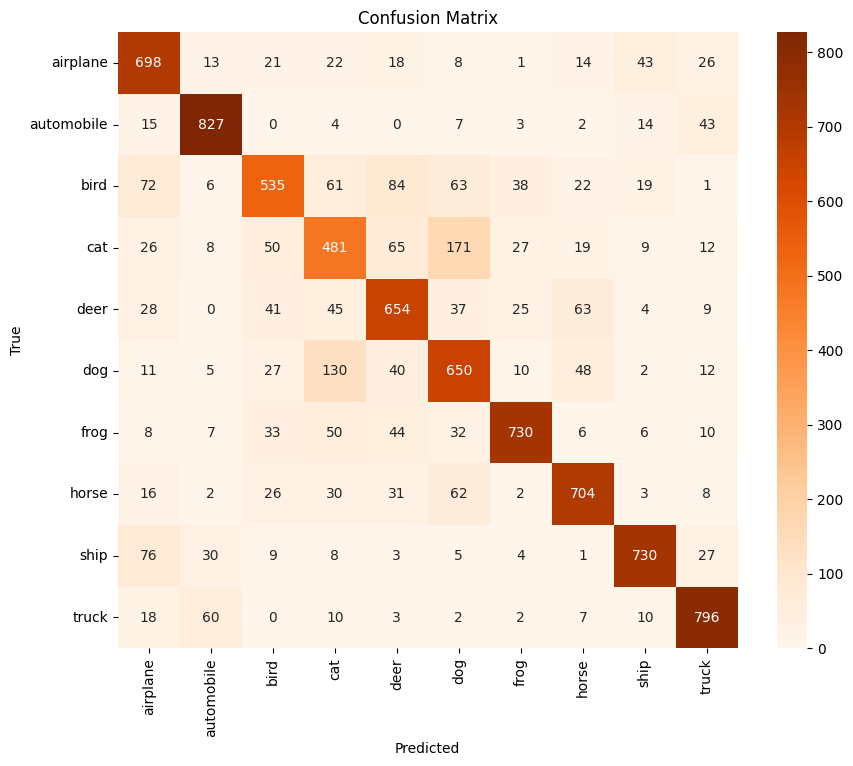

In [ ]:
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))


In [ ]:
metrics(y_true, y_pred)

Precision: 0.76
Recall: 0.76
F1 Score: 0.76


In [ ]:
torch.save(model.state_dict(), 'vgg_base_model.pth')

## L2 Regularization

Epoch: 1  Train Accuracy: 36.56%  Train Loss: 1.6894953960334511  Validation Accuracy: 51.34%  Validation Loss: 1.3181665138149938
Epoch: 2  Train Accuracy: 56.69%  Train Loss: 1.1966035867753457  Validation Accuracy: 62.29%  Validation Loss: 1.0519067991709878
Epoch: 3  Train Accuracy: 66.28%  Train Loss: 0.9582897108076551  Validation Accuracy: 67.43%  Validation Loss: 0.9287511321669775
Epoch: 4  Train Accuracy: 71.92%  Train Loss: 0.8089082654299076  Validation Accuracy: 70.64%  Validation Loss: 0.8412881351954548
Epoch: 5  Train Accuracy: 76.00%  Train Loss: 0.7014219633883356  Validation Accuracy: 73.48%  Validation Loss: 0.7701536114756943
Test Accuracy: 72 %
Test Loss: 0.7941838029428576


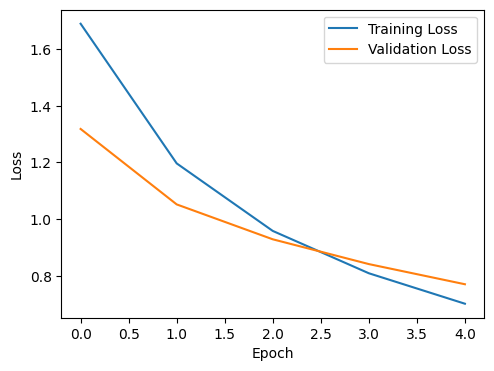

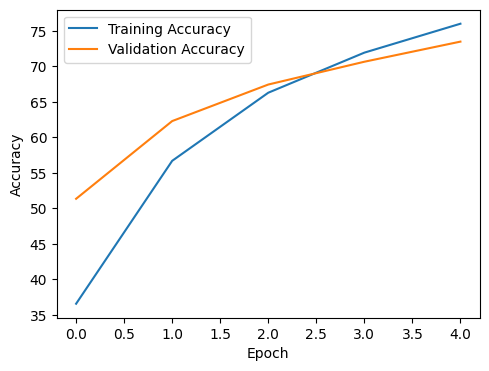

In [ ]:
model = VGG13()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Training and Validation
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

#Test Accuracy and Loss
test_accuracy(model, test_loader)

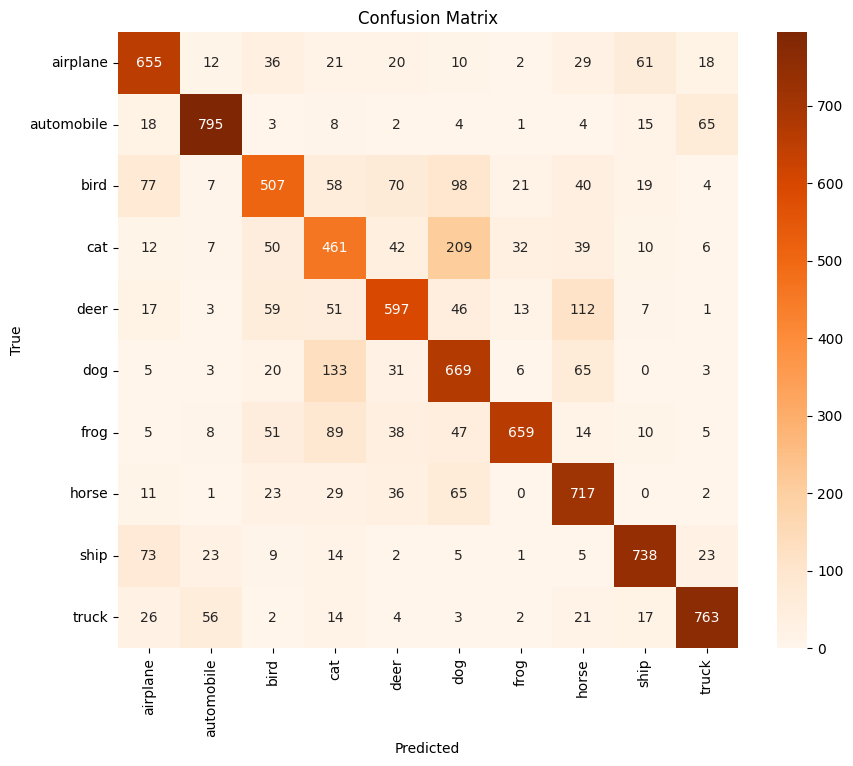

In [ ]:
y_true = []
y_pred = []
confusion_plot(model, test_loader)

In [ ]:
metrics(y_true, y_pred)

Precision: 0.75
Recall: 0.75
F1 Score: 0.75


In [ ]:
torch.save(model.state_dict(), 'vgg_l2_model.pth')